<a href="https://colab.research.google.com/github/ALejandroCh17/Tennis-Ball-Robot/blob/main/rally_rover_tennis_ball_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tennis Ball Detection with Convolutional Neural Network

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importing modules

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf
import os
import random

## Exploratory Data Analysis

In [3]:
# Define the paths to the folders containing the images
folders = [
    '/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/train/balls',
    '/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/train/empty',
    '/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/test/balls',
    '/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/test/empty'
]

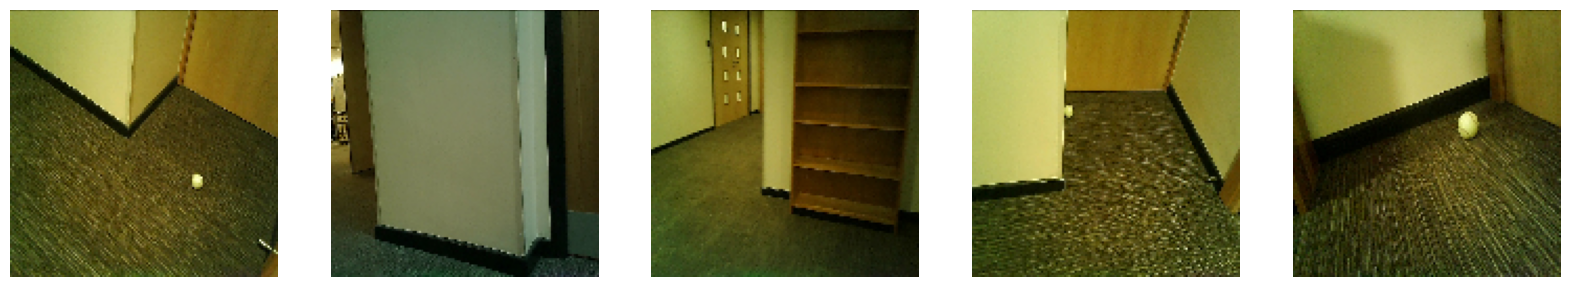

In [4]:
# Gather all image paths from the folders
all_image_paths = []
for folder in folders:
    for image_name in os.listdir(folder):
        all_image_paths.append(os.path.join(folder, image_name))

# Select 5 random images from the entire dataset
selected_image_paths = random.sample(all_image_paths, 5)

# Plot the selected images
plt.figure(figsize=(20, 4))
for i, img_path in enumerate(selected_image_paths):
    img = load_img(img_path, color_mode='rgb', target_size=(128, 128))  # Load and resize the image
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

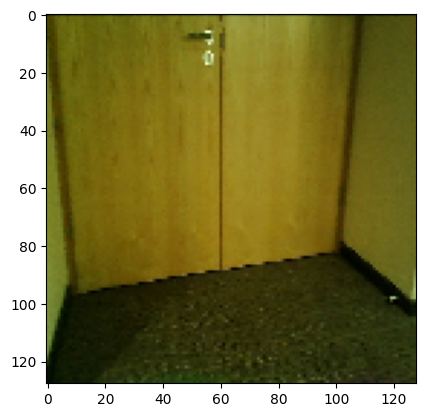

In [5]:
# Showing no ball image
img = load_img('/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/test/empty/empty517.jpg', color_mode='rgb', target_size=(128,128))
img_arr = img_to_array(img)
plt.imshow(img)

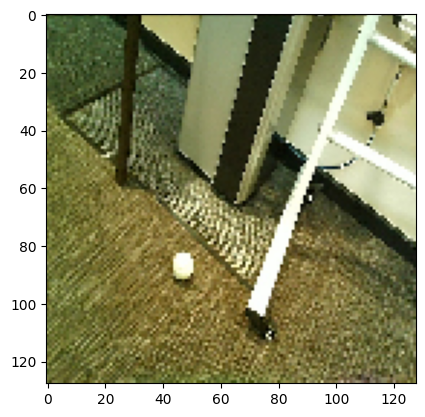

In [6]:
# Showing ball image
img = load_img('/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/test/balls/ball97.jpg', color_mode='rgb', target_size=(128,128))
img_arr = img_to_array(img)
plt.imshow(img)

A comparison between both image confirms our expectation of a ball either present or not present.

In [ ]:
# Converts images to arrays for processing.
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = load_img(os.path.join(folder,filename), color_mode='rgb', target_size=(128, 128))
        img_arr = img_to_array(img)
        images.append(img_arr)
    return images

**Investigating Label Distribution**

In [ ]:
# Converting training sets to num arrays
x_train_balls = load_images_from_folder('/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/train/balls')
x_train_empty = load_images_from_folder('/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/train/empty')
x_test_balls = load_images_from_folder('/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/test/balls')
x_test_empty = load_images_from_folder('/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/test/empty')

In [ ]:
# Set the directory for each class
dir_train_balls = '/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/train/balls'
dir_train_empty = '/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/train/empty'
dir_test_balls = '/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/test/balls'
dir_test_empty = '/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/test/empty'

# Count the number of images in each directory
count_train_balls = len(os.listdir(dir_train_balls))
count_train_empty = len(os.listdir(dir_train_empty))
count_test_balls = len(os.listdir(dir_test_balls))
count_test_empty = len(os.listdir(dir_test_empty))

total_balls = count_train_balls + count_test_balls
total_empty = count_train_empty + count_test_empty

print(f'Balls: {total_balls}')
print(f'Empty: {total_empty}')

In [ ]:
# Concatenating no-ball and yes-ball sets together
y_train = np.concatenate( ( np.ones(len(x_train_balls)), np.zeros(len(x_train_empty))) )
x_train = np.concatenate( (np.array(x_train_balls), np.array(x_train_empty) ) )
y_test = np.concatenate( (np.ones(len(x_test_balls)), np.zeros(len(x_test_empty))) )
x_test = np.concatenate( (np.array(x_test_balls), np.array(x_test_empty) ) )

In [ ]:
# Combine the datasets
x_combined = np.concatenate((x_train, x_test))
y_combined = np.concatenate((y_train, y_test))

In [ ]:
# Shuffle the combined dataset
# It's important to shuffle the data before splitting to ensure randomness
randomize_combined = np.arange(len(y_combined))
np.random.shuffle(randomize_combined)
x_combined = x_combined[randomize_combined]
y_combined = y_combined[randomize_combined]

In [ ]:
# New Split
x_train_new, x_test_new, y_train_new, y_test_new = train_test_split(x_combined, y_combined, test_size=0.30, random_state=42)

# Normalize the pixel values if you haven't done it before
x_train_new = x_train_new / 255
x_test_new = x_test_new / 255

In [ ]:
# Display the shapes of the resulting datasets
print("X_train shape:", x_train_new.shape)
print("X_test shape:", x_test_new.shape)
print("y_train shape:", y_train_new.shape)
print("y_test shape:", y_test_new.shape)

In [ ]:
x_train_new[400:405]

In [ ]:
y_train_new[400:405]

## Model

In [ ]:
model = Sequential()

model.add(Conv2D(16, kernel_size=3, activation='relu', input_shape=(128,128,3)))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(units=20, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=5, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics = ['accuracy'])

## Training model

In [ ]:
model.fit(x=x_train_new, y=y_train_new, validation_data=(x_test_new, y_test_new), epochs=10)

## History

In [ ]:
history = pd.DataFrame(model.history.history)
model_loss = history.drop(columns=['accuracy', 'val_accuracy'])
model_accuracy = history.drop(columns=['loss', 'val_loss'])

In [ ]:
model_loss.plot()

In [ ]:
model_accuracy.plot()

## Model evaluation

In [ ]:
predictions = np.rint(model.predict(x_test))

In [ ]:
print( classification_report(y_test, predictions) )

In [ ]:
confusion_matrix(y_test, predictions)

In [ ]:
sample = 43
plt.imshow(x_test[sample], cmap=plt.cm.gray_r)
plt.title('prediction: ' + str(predictions[sample]) )

## Save model

In [ ]:
model.save('model.h5')

## Load model

In [ ]:
model = tf.keras.models.load_model('model.h5')